In [7]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
from glob import glob
import re
import scipy
import os
import sklearn
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer
import json
import pickle
import keras
import tensorflow as tf
from keras.models import load_model
import model_functions as mf
import argparse
import itertools
import time
import matplotlib.pyplot as plt
import matplotlib

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
main_dir = "C:/Users/tslee/IRP Data/DMF_Internship/DATA/HPC_Reports/fourth_run/"
sub_dir = ["AC_plaid_reports", "AC_whited_reports",
           "RMS_plaid_reports", "RMS_whited_reports"]

In [3]:
#columns : ["dataset", "input_type", "algorithm", "sample_size", "frequency",
#             "precision", "recall", "F1-score", "compute_time(sec)"]
temp_metric_list = []
num_classes = 11
for folder in sub_dir:
    input_type = folder.split("_")[0]
    dataset = "_".join(("_".join(folder.split("_")[1:])).split("_")[:-1])
    for filename in glob((main_dir+folder + "/*.json")):
        #print(filename)
        algorithm = filename.split("\\")[1].split("_")[0]
        sample_size = int(filename.split("\\")[1].split("_")[1].split("samples")[0])
        freq = int(filename.split("\\")[1].split("_")[2].split("Hz")[0])
        #print(algorithm, sample_size, freq)
        with open(filename, "r") as readfile:
            json_data = json.load(readfile)
        precision = json_data["weighted avg"]["precision"]
        recall = json_data["weighted avg"]["recall"]
        f1_score = json_data["weighted avg"]["f1-score"]

        #getting compute time as well
        txt_log_base = "_log.txt"
        samples_per_class = int(sample_size/num_classes)
        txt_log_size = txt_log_base
        if algorithm in ["knn", "svm", "xgboost"]:
            txt_log_name = "benchmark" + txt_log_size
            model_file = filename[:-11] + "model.pkl"
        else:
            txt_log_name = "NN" + txt_log_size
            model_file = filename[:-11] + "model.h5"

        #using glob to find all files
        seconds = np.nan
        all_lines = []
        for filename2 in glob((main_dir+folder+"/*"+txt_log_name)):
            #print(filename)
            with open(filename2) as text_file:
                file_lines = text_file.readlines()
            all_lines.extend(file_lines)
        
        myregex = algorithm + " " + str(samples_per_class) + " sample size at " + str(freq) + " Hz :"
        #print(myregex)
        for line in all_lines:
            flag = re.findall(myregex, line, re.IGNORECASE)
            if flag:
                    seconds = round(float(line.split(":")[1].split(" seconds")[0]), 2)
                    #print(seconds, line)
                    break
            
        #getting file size as well
        file_size = int(os.path.getsize(model_file)) / 1_000_000 #converting to MB
        #print(file_size)

        file_meta = [dataset, input_type, algorithm, sample_size, 
                     freq, precision, recall, f1_score, seconds, file_size]
        temp_metric_list.append(file_meta)
metrics_df = pd.DataFrame(temp_metric_list, columns=["dataset", "input_type", "algorithm", 
                                                        "sample_size", "frequency",
                                                        "precision", "recall", "F1-score", 
                                                        "compute_time(sec)", "file_size(MB)"])

In [75]:
print(metrics_df["compute_time(sec)"].sum())

126266.80140852928


Max Validation Categorical Accuracy: 95.9999978542328%


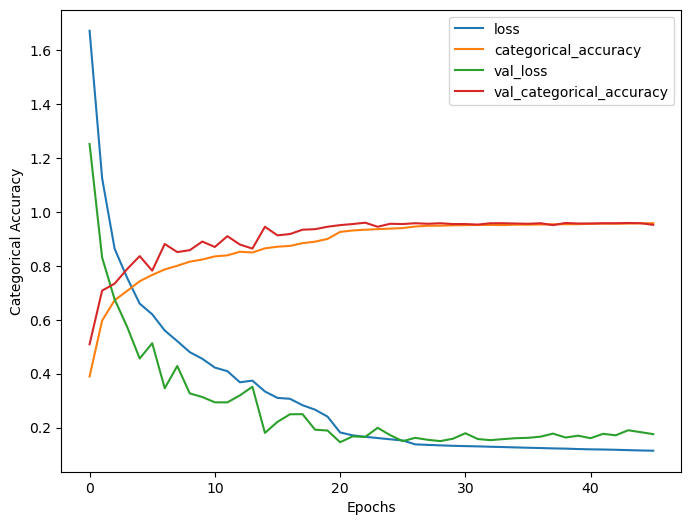

In [21]:
#getting history plot from various NN algos
source_dir = "C:/Users/tslee/IRP Data/DMF_Internship/DATA/HPC_Reports/fourth_run/"
NN_in_type = "AC" #Can be AC or RMS
NN_samples = 22000  #Can be [550, 1100, 5500, 11000, 22000]
NN_freq = 1000 #RMS:[10, 50, 150, 500, 1000]   AC:[150, 500, 1000]
NN_dataset = "plaid_and_whited" #Can be ["plaid", "whited", "plaid_and_whited"]

experiment_dir = source_dir + NN_in_type + "_" + NN_dataset + "_reports/"
history_path = experiment_dir + "NN_" + str(NN_samples) + "samples_" + str(NN_freq) + "Hz_history.csv"

NN_history = pd.read_csv(history_path).iloc[:, 1:] #dropping the first colum with epochs
fig = plt.figure(figsize=(8,6))
plt.plot(NN_history, label=NN_history.columns.values)
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.legend()
print("Max Validation Categorical Accuracy: " + str(NN_history["val_categorical_accuracy"].max()*100) + "%")

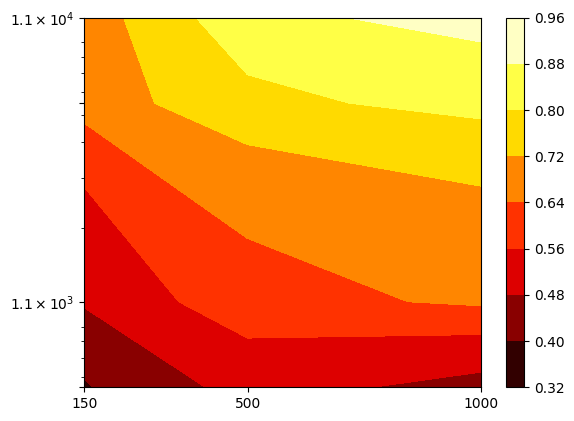

In [4]:
#creating contour plot
contour_dataset = "plaid"
contour_input = "AC"
contour_algo = "NN"

contour_results = metrics_df[(metrics_df["algorithm"]==contour_algo) &
                             (metrics_df["dataset"]==contour_dataset) &
                             (metrics_df["input_type"]==contour_input)]
pivot = contour_results.pivot(index="frequency", columns="sample_size", values="F1-score")
X,Y = np.meshgrid(pivot.index.to_numpy(), pivot.columns.to_numpy())

cs = plt.contourf(X, Y, pivot.values.T, cmap="hot")

#plt.xscale("symlog")
plt.yscale("log")
plt.xticks(pivot.index)
plt.yticks(pivot.columns)
plt.colorbar(cs)
plt.show()

Text(0, 0.5, 'F1 Score')

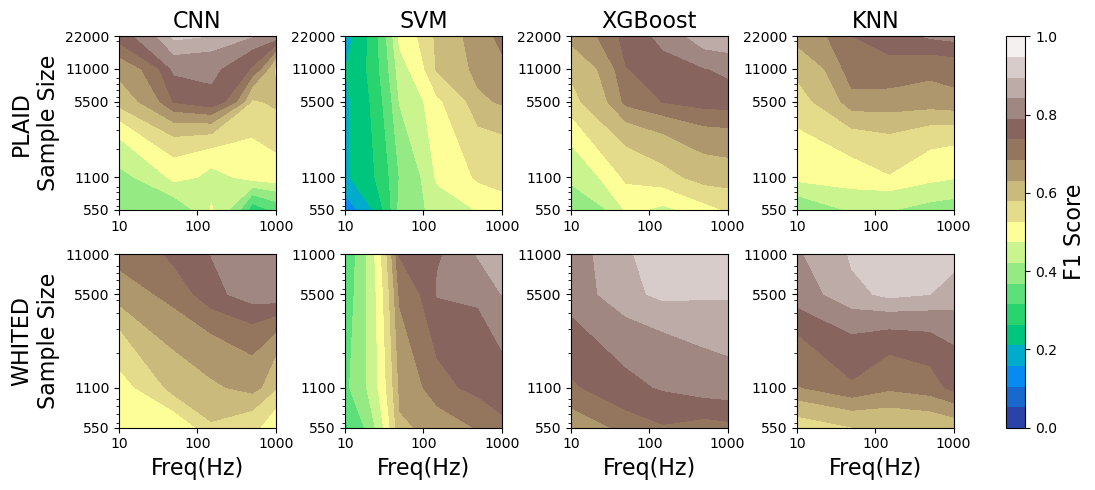

In [102]:
plt.cla()
plt.clf()
plt.close()
#creating contour plot subplots
datasets = ["plaid", "whited"]
algorithms = ["NN", "svm", "xgboost", "knn"]
input_type = "RMS"

dict_dataset = {"plaid":"PLAID", "whited":"WHITED"}
dict_algo = {"NN":"CNN", "svm":"SVM", "xgboost":"XGBoost", "knn":"KNN"}
fig, ax = plt.subplots(nrows=len(datasets), ncols=len(algorithms), figsize=(12,5))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        contour_results = metrics_df[(metrics_df["algorithm"]==algorithms[j]) &
                                        (metrics_df["dataset"]==datasets[i]) &
                                        (metrics_df["input_type"]==input_type)]
        pivot = contour_results.pivot(index="frequency", columns="sample_size", values="F1-score")
        X,Y = np.meshgrid(pivot.index.to_numpy(), pivot.columns.to_numpy())

        sub = col.contourf(X, Y, pivot.values.T, cmap="terrain", levels=np.linspace(0, 1, 20))
        sub.set_clim(0, 1)
        col.set_xscale("log")
        col.set_yscale("log")
        col.set_ylim(Y[0, 0], Y[-1, 0])
        #col.set_xlabel("Freq(Hz)", fontsize=8)
        #col.set_ylabel("Sample Size", fontsize=8)
        col.set_xticks([10, 100, 1000])
        #col.set_xticks([150, 500, 1000])
        col.set_yticks(Y[0:, 0])
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        col.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #col.gca().xaxis.ticklabel_format(style='plain')
        #col.ticklabel_format(style="plain")
        #fig.gca().yaxis.ticklabel_format(style='plain')
        #col.ticklabel_format(axis="both", style="plain", useOffset=False, scilimits=(-5, 8))
        col.tick_params(axis="x", which="major", labelsize=10)
        col.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=False)

        #setting column and row labels
        if j==0: #rows
            ylabel = dict_dataset[datasets[i]] + "\n" + "Sample Size"
            col.set_ylabel(ylabel, fontsize=16)
        if i==0: #columns
            col.set_title(dict_algo[algorithms[j]], fontsize=16)
        if i==1: #last row then set xlabel
            col.set_xlabel("Freq(Hz)", fontsize=16)
        #col.set_xticks([])
#plt.xticks(fontsize=8)
#plt.yticks(fontsize=8)
fig.tight_layout()
cb = fig.colorbar(sub, ax=ax.ravel().tolist(), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], boundaries=np.linspace(0, 1, 5))
cb.ax.set_ylabel("F1 Score", fontsize=16)

In [40]:
#finding best metrics for each algorithm on each dataset
grouped = metrics_df.loc[metrics_df.groupby(["dataset", "input_type"])["F1-score"].idxmax()]\
                        [["dataset", "input_type", "algorithm", "sample_size", "frequency", "F1-score"]]

print(grouped)

    dataset input_type algorithm  sample_size  frequency  F1-score
21    plaid         AC        NN        22000       1000  0.986245
147   plaid        RMS        NN        22000         50  0.910166
74   whited         AC        NN        11000        500  0.988570
210  whited        RMS       knn        11000        150  0.939566


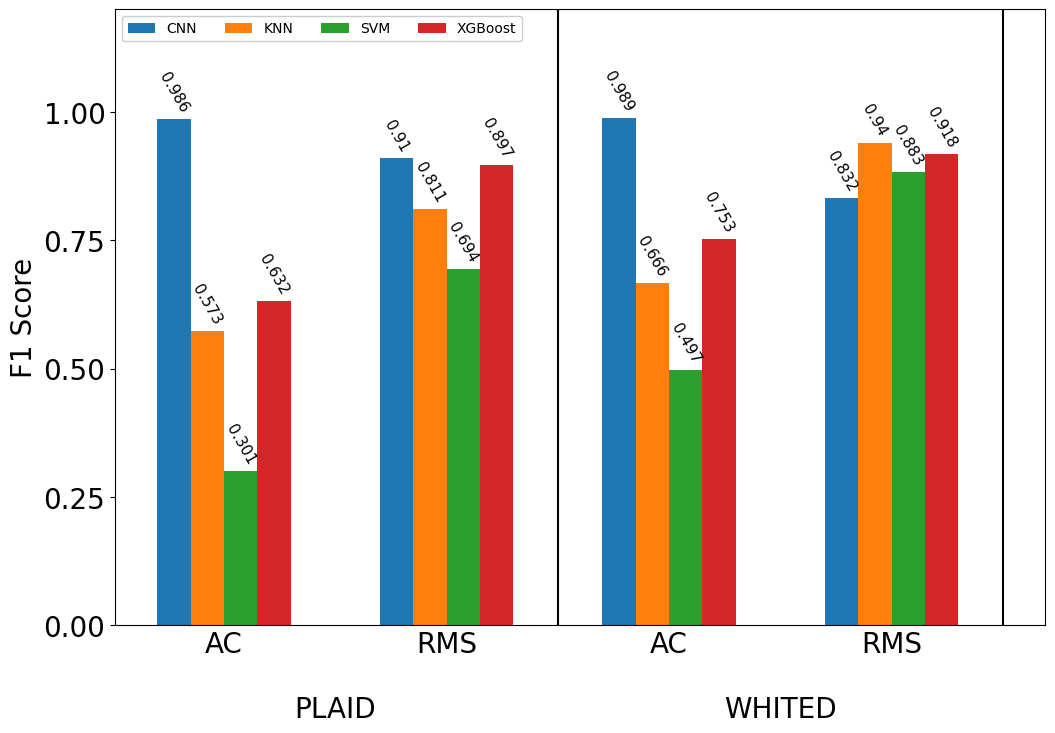

In [6]:
#creating bar graph of the best performing model for each dataset and it's respective data type
bar_grouped = metrics_df.loc[metrics_df.groupby(["dataset", "input_type", "algorithm"])["F1-score"].idxmax()]
#print(bar_grouped)
dict_dataset = {"plaid":"PLAID", "whited":"WHITED"}
dict_algo = {"NN":"CNN", "svm":"SVM", "xgboost":"XGBoost", "knn":"KNN"}

algorithms = np.unique(bar_grouped["algorithm"])
categories = len(bar_grouped.groupby(["dataset"]))
x = np.arange(len(bar_grouped.groupby(["dataset", "input_type"])))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (12, 8))

for idx, algo in enumerate(algorithms):
    bars = bar_grouped[bar_grouped["algorithm"]==algo]
    offset = width * idx
    rects = ax.bar(x + offset, round(bars["F1-score"], 3), width, label=dict_algo[algo])
    ax.bar_label(rects, padding=3, fontsize=11, rotation=-60)

list_ticks = list()
for i in np.arange(categories):
    list_ticks.extend([2*i+1.5*width, (2*i+0.5)+1.5*width, (2*i+1)+1.5*width])
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Score', fontsize=20)
#ax.set_title('Best Performing Algorithm for Each Dataset and Input Type')
ax.set_xticks(list_ticks)
ax.set_xticklabels(("AC", "\n\nPLAID", "RMS", "AC", "\n\nWHITED", "RMS"), ha="center")
ax.tick_params(axis="x", which="major", labelsize=20)
ax.tick_params(axis='x', which='both',length=0)
ax.tick_params(axis="y", which="major", labelsize=20)
ax.legend(loc='upper left', ncols=4, facecolor="white", framealpha=1)
ax.set_ylim(0, 1.20)
ax.set_yticks(np.linspace(0, 1, 5))

ax.vlines(1.725, 0, 1.5, colors="black")
ax.vlines(3.725, 0, 1.5, colors="black")

plt.show()

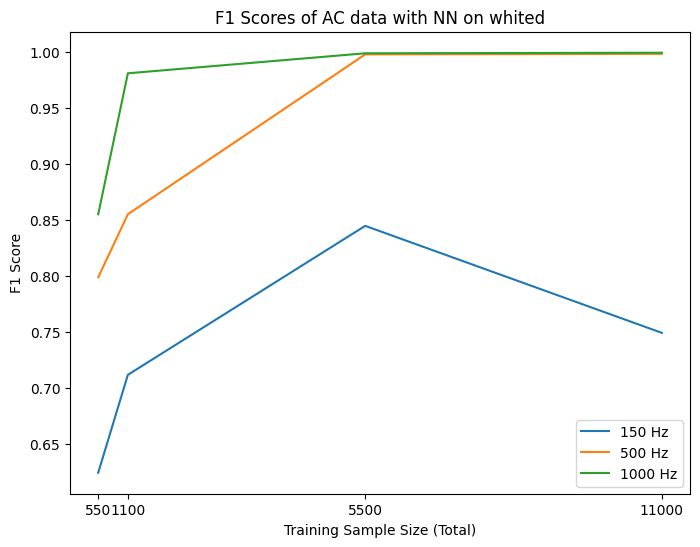

In [28]:
dataset = "whited"
input_type = "AC"
model = "NN"
best_models = metrics_df[(metrics_df["dataset"]==dataset) & (metrics_df["input_type"]==input_type) & \
                            (metrics_df["algorithm"]==model)]
fig, axs = plt.subplots(figsize=(8,6))
freqs = np.unique(best_models["frequency"])
for freq in freqs:
    masked_data = best_models[best_models["frequency"]==freq].sort_values(by=["sample_size"])
    axs.plot(masked_data["sample_size"], masked_data["F1-score"], label=(str(freq)+" Hz"))
axs.set_title(("F1 Scores of AC data with " + model +" on " + dataset))
axs.set_xlabel("Training Sample Size (Total)")
axs.set_ylabel("F1 Score")
axs.set_xticks(masked_data["sample_size"])
axs.legend()

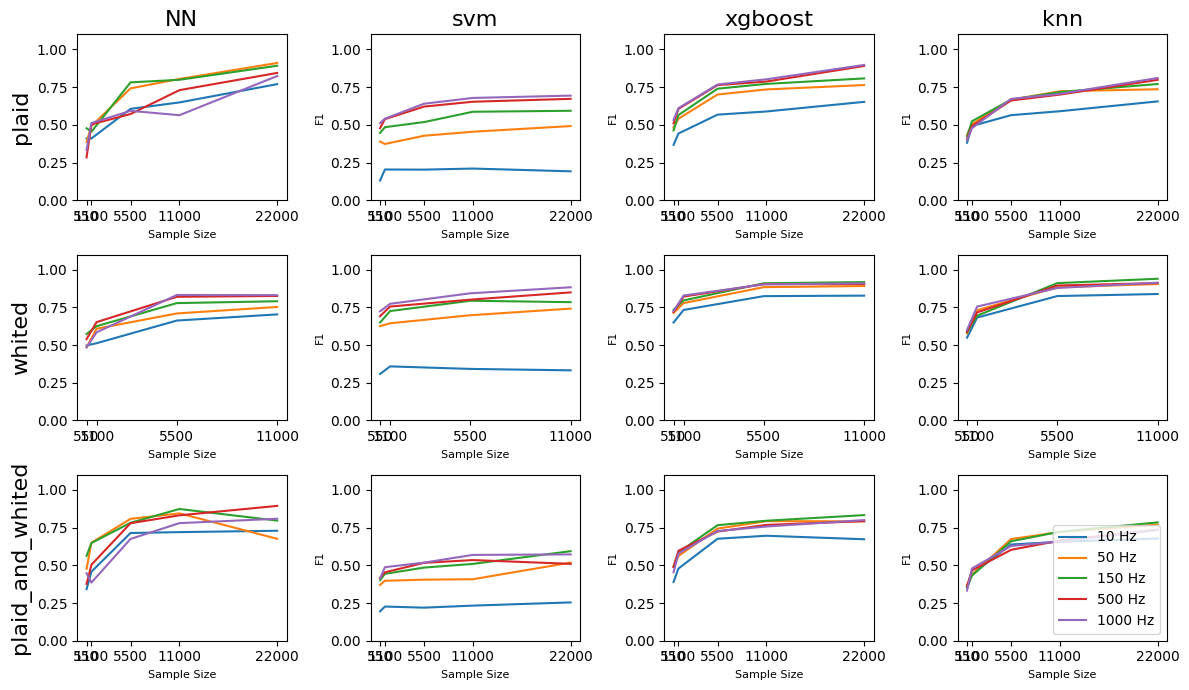

In [33]:
datasets = ["plaid", "whited", "plaid_and_whited"]
algorithms = ["NN", "svm", "xgboost", "knn"]
input_type = "RMS"
fig, ax = plt.subplots(nrows=len(datasets), ncols=len(algorithms), figsize=(12,7))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        line_results = metrics_df[(metrics_df["algorithm"]==algorithms[j]) &
                                        (metrics_df["dataset"]==datasets[i]) &
                                        (metrics_df["input_type"]==input_type)]
        freqs = np.unique(line_results["frequency"])
        for freq in freqs:
            masked_line = line_results[line_results["frequency"]==freq].sort_values(by=["sample_size"])
            line = col.plot(masked_line["sample_size"], masked_line["F1-score"], label=(str(freq)+" Hz"))
        col.set_ylim(0, 1.1)
        col.set_xticks(masked_line["sample_size"])
        col.set_yticks(np.linspace(0, 1, 5))
        col.set_xlabel("Sample Size", fontsize=8)
        col.set_ylabel("F1", fontsize=8)
        #col.set_xscale("log")
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

        #setting column and row labels
        if j==0: #rows
            col.set_ylabel(datasets[i], fontsize=16)
        if i==0:
            col.set_title(algorithms[j], fontsize=16)

fig.tight_layout()
col.legend(loc="lower right")

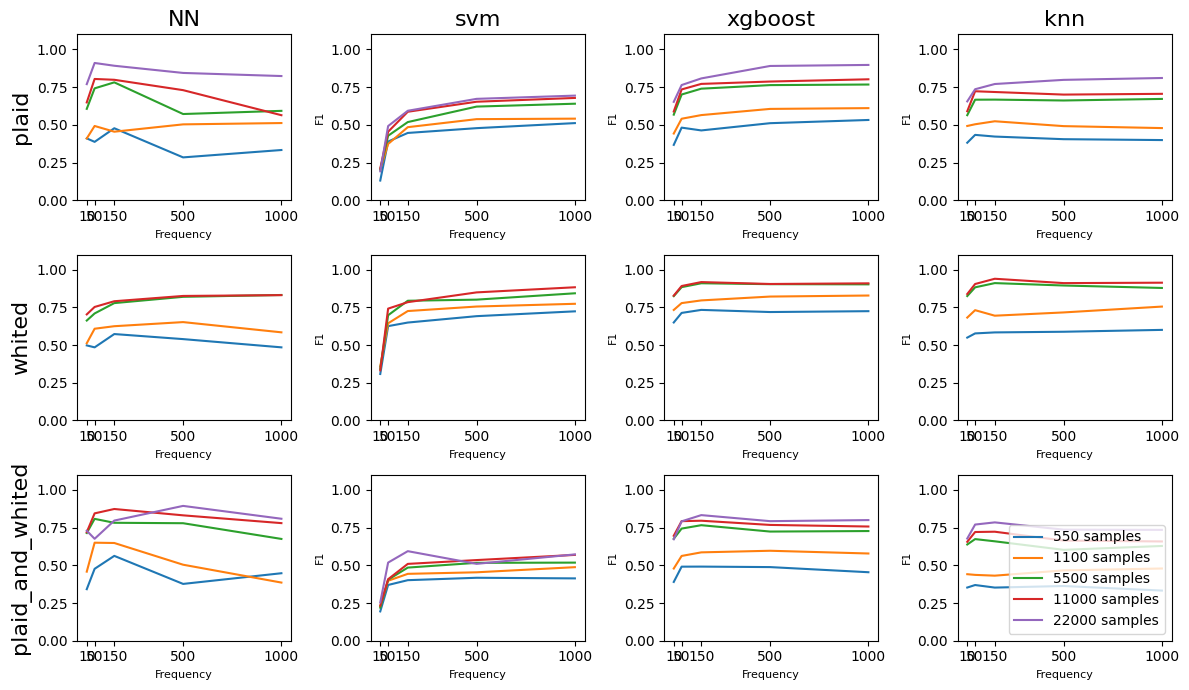

In [32]:
datasets = ["plaid", "whited", "plaid_and_whited"]
algorithms = ["NN", "svm", "xgboost", "knn"]
input_type = "RMS"
fig, ax = plt.subplots(nrows=len(datasets), ncols=len(algorithms), figsize=(12,7))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        line_results = metrics_df[(metrics_df["algorithm"]==algorithms[j]) &
                                        (metrics_df["dataset"]==datasets[i]) &
                                        (metrics_df["input_type"]==input_type)]
        samples = np.unique(line_results["sample_size"])
        for sample in samples:
            masked_line = line_results[line_results["sample_size"]==sample].sort_values(by=["frequency"])
            line = col.plot(masked_line["frequency"], masked_line["F1-score"], label=(str(sample)+" samples"))
        col.set_ylim(0, 1.1)
        col.set_xticks(masked_line["frequency"])
        col.set_yticks(np.linspace(0, 1, 5))
        col.set_xlabel("Frequency", fontsize=8)
        col.set_ylabel("F1", fontsize=8)
        #col.set_xscale("log")
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

        #setting column and row labels
        if j==0: #rows
            col.set_ylabel(datasets[i], fontsize=16)
        if i==0:
            col.set_title(algorithms[j], fontsize=16)

fig.tight_layout()
col.legend(loc="lower right")

In [28]:
#applying polynomial regression to all models in metrics_df
metrics_grouped = metrics_df.groupby(by=["dataset", "input_type", "algorithm"])

poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly_list = []
for group_name, df_group in metrics_grouped:
    temp_list = list(group_name)

    X = df_group[["sample_size", "frequency"]]
    X = (X-X.min())/(X.max()-X.min())
    Y = df_group["F1-score"]

    poly_features = poly.fit_transform(X)
    poly_reg_model = sklearn.linear_model.LinearRegression()
    poly_reg_model.fit(poly_features, Y)
    Y_pred_poly = poly_reg_model.predict(poly_features)
    R2_poly_score = sklearn.metrics.r2_score(Y, Y_pred_poly)

    temp_list.extend(poly_reg_model.coef_)
    temp_list.extend([R2_poly_score])

    poly_list.append(temp_list)
column_names = ["dataset", "input_type", "algorithm"]
column_names.extend(poly.get_feature_names_out())
column_names.extend(["R^2_score"])
regression_model_df = pd.DataFrame(poly_list, columns=column_names)
#print(regression_model_df)

latex_reg_model = regression_model_df.round(2).to_latex(index=False)
print(latex_reg_model)

\begin{tabular}{lllrrrrrr}
\toprule
dataset & input\_type & algorithm &  sample\_size &  frequency &  sample\_size\textasciicircum 2 &  sample\_size frequency &  frequency\textasciicircum 2 &  R\textasciicircum 2\_score \\
\midrule
  plaid &         AC &        NN &         0.96 &       0.37 &          -0.56 &                   0.03 &        -0.24 &       0.92 \\
  plaid &         AC &       knn &         0.82 &       0.04 &          -0.49 &                   0.05 &        -0.04 &       0.99 \\
  plaid &         AC &       svm &         0.23 &       0.14 &          -0.30 &                   0.07 &        -0.11 &       0.90 \\
  plaid &         AC &   xgboost &         1.10 &       0.20 &          -0.79 &                   0.03 &        -0.14 &       0.97 \\
  plaid &        RMS &        NN &         0.91 &       0.02 &          -0.49 &                  -0.01 &        -0.08 &       0.83 \\
  plaid &        RMS &       knn &         0.75 &       0.12 &          -0.49 &                   

C:\Users\tslee\AppData\Local\Temp\ipykernel_3648\2143800289.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_reg_model = regression_model_df.round(2).to_latex(index=False)


In [ ]:
#creating contour plot
from mpl_toolkits import mplot3d
#%matplotlib widget

contour_dataset = "whited"
contour_input = "AC"
contour_algo = "NN"

contour_results = metrics_df[(metrics_df["algorithm"]==contour_algo) &
                             (metrics_df["dataset"]==contour_dataset) &
                             (metrics_df["input_type"]==contour_input)]
pivot = contour_results.pivot(index="frequency", columns="sample_size", values="F1-score")

fig = plt.figure()
ax = plt.axes(projection="3d")
X,Y = np.meshgrid(pivot.index.to_numpy(), pivot.columns.to_numpy())

cs = ax.plot_surface(X, Y, pivot.values.T, cmap="hot")

#plt.xscale("symlog")
#plt.yscale("log")
#plt.xticks(pivot.index)
#plt.yticks(pivot.columns)
#plt.colorbar(cs)
#plt.show()

In [12]:
#getting average difference between AC and RMS results
#ac_rms = metrics_df.groupby(by=["dataset", "algorithm", "frequency", "sample_size"])

ac_df = metrics_df[metrics_df["input_type"] == "AC"] 
rms_df = metrics_df[metrics_df["input_type"] == "RMS"]

merged = ac_df.merge(rms_df, on=["dataset", "algorithm", "frequency", "sample_size"]) #AC on the left

merged["diff"] = merged["F1-score_y"] - merged["F1-score_x"]

avg_diff = merged["diff"].mean()
print(avg_diff)

0.20095850178804178


In [26]:
#getting the parameters of the best performing models from each type
idx = metrics_df.groupby(by=["dataset", "input_type", "algorithm"])["F1-score"].transform(max) == metrics_df["F1-score"]
best_model_params = metrics_df[idx]
#print(best_model_params)
#converting to latex form
best_model_params = best_model_params.drop(labels=["precision", "recall"], axis=1)
#print(best_model_params)
best_model_params["compute_time(sec)"] = best_model_params["compute_time(sec)"].round(2)
best_model_params["file_size(MB)"] = best_model_params["file_size(MB)"].round(2)
best_model_params["F1-score"] = best_model_params["F1-score"].round(4)

latex_tab = best_model_params.to_latex(index=False)
print(latex_tab)

\begin{tabular}{lllrrrrr}
\toprule
dataset & input\_type & algorithm &  sample\_size &  frequency &  F1-score &  compute\_time(sec) &  file\_size(MB) \\
\midrule
  plaid &         AC &       knn &        22000 &       1000 &    0.5731 &               1.27 &         176.59 \\
  plaid &         AC &        NN &        22000 &       1000 &    0.9862 &            9954.42 &           3.14 \\
  plaid &         AC &       svm &         5500 &        500 &    0.3010 &              24.79 &          92.47 \\
  plaid &         AC &   xgboost &        22000 &       1000 &    0.6321 &             905.44 &           2.33 \\
 whited &         AC &       knn &        11000 &       1000 &    0.6665 &               0.68 &          88.46 \\
 whited &         AC &        NN &        11000 &        500 &    0.9886 &            2380.90 &           3.14 \\
 whited &         AC &       svm &         5500 &        500 &    0.4969 &              41.11 &          70.87 \\
 whited &         AC &   xgboost &      

C:\Users\tslee\AppData\Local\Temp\ipykernel_3648\2995685094.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_tab = best_model_params.to_latex(index=False)


In [30]:
#getting total compute time
total_time = metrics_df["compute_time(sec)"].sum()
print(total_time/3600, " hours")

25.649463888888885  hours


In [23]:
#loading in the labels and getting number of each type of appliance

label_dir = "C:/Users/tslee/IRP Data/DMF_Internship/DATA/"
plaid_labels = np.load((label_dir+"PLAID_5000Hz_labels.npy"), allow_pickle=True)
whited_labels = np.load((label_dir+"WHITED_5000Hz_AC_labels.npy"), allow_pickle=True)

plaid_occ = pd.DataFrame(pd.DataFrame(plaid_labels, columns=["appliance"]).value_counts()).reset_index()

whited_classes = np.array(['AC', 'CFL', 'Fan', 'Fridge', 'HairDryer',
                            'Heater', 'LightBulb', 'Laptop', 'Microwave', 'VacuumCleaner',
                            'WashingMachine'])
plaid_classes = np.array(['Air Conditioner', "Compact Fluorescent Lamp", 'Fan', 'Fridge', 'Hairdryer',
                            'Heater', "Incandescent Light Bulb", 'Laptop', 'Microwave', 'Vacuum',
                            'Washing Machine'])


whited_mask = np.isin(whited_labels, whited_classes).reshape((-1,))
whited_labels = whited_labels[whited_mask]

for idx, class_label in enumerate(whited_classes):
    whited_labels[whited_labels == class_label] = plaid_classes[idx]

whited_occ = pd.DataFrame(pd.DataFrame(whited_labels, columns=["appliance"]).value_counts()).reset_index()


label_df = pd.merge(plaid_occ, whited_occ, how="left", on=["appliance"])
print(label_df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
               appliance &  0\_x &  0\_y \\
\midrule
               Hairdryer &  243 &   60 \\
               Microwave &  226 &   30 \\
Compact Fluorescent Lamp &  216 &   20 \\
         Air Conditioner &  189 &   10 \\
                  Laptop &  154 &   10 \\
                     Fan &  152 &   50 \\
 Incandescent Light Bulb &  143 &   70 \\
                  Heater &   82 &   10 \\
                  Vacuum &   73 &   40 \\
         Washing Machine &   73 &   10 \\
                  Fridge &   66 &   10 \\
\bottomrule
\end{tabular}



C:\Users\tslee\AppData\Local\Temp\ipykernel_23204\3739605073.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(label_df.to_latex(index=False))
